In [4]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.models import (
    NaiveSeasonal, MovingAverage, 
    NBEATSModel, KalmanFilter, GaussianProcessFilter, 
    ARIMA, RegressionModel)

import darts.anomaly_detection.score as S
import darts.anomaly_detection.detector as D
import darts.anomaly_detection.anomalyModel as AM

In [5]:
series = AirPassengersDataset().load()
series_train, series_test = series.split_before(pd.Timestamp("19580101"))

np_anomalies = np.random.choice(a = [0,1], size = len(series_test), p = [0.7, 0.3])
anomalies = TimeSeries.from_times_and_values(series_test._time_index, np_anomalies)

# Anomaly Model (Trained model + scorer)

In [6]:
# possible models
# filter: Kallman/MovingAverage
# model: NaiveSeasonal/ARIMA

model_NS = AM.AnomalyModel(
    model_to_train= NaiveSeasonal(K=12),
    scorer_fn= S.L1()
)
anomaly_score_NS = model_NS.run_compute(series, pd.Timestamp("19580101"))

"""
model_ARIMA = AM.AnomalyModel(
    model_to_train= ARIMA(p=12,d=2,q=3),
    scorer_fn= S.L1()
)
anomaly_score_ARIMA = model_ARIMA.run_compute(series, pd.Timestamp("19580101"))
"""

model_RM = AM.AnomalyModel(
    model_to_train= RegressionModel(lags=10),
    scorer_fn= S.L1()
)
anomaly_score_RM = model_RM.run_compute(series, pd.Timestamp("19580101"))

model_MA = AM.AnomalyModel(
    model_to_train= MovingAverage(window=10),
    scorer_fn= S.L1()
)
anomaly_score_MA = model_MA.run_compute(series, pd.Timestamp("19580101"))

model_Kalman = AM.AnomalyModel(
    model_to_train= KalmanFilter(),
    scorer_fn= S.L1()
)
anomaly_score_Kalman = model_Kalman.run_compute(series, pd.Timestamp("19580101"))

model_Kalman_diff = AM.AnomalyModel(
    model_to_train= KalmanFilter(),
    scorer_fn= S.difference()
)
anomaly_score_Kalman_diff = model_Kalman_diff.run_compute(series, pd.Timestamp("19580101"))

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

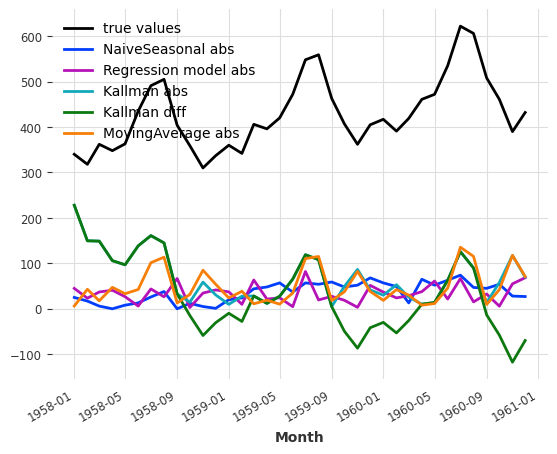

In [7]:
series_test.plot(label="true values")
anomaly_score_NS.plot(label="NaiveSeasonal abs")
#anomaly_score_ARIMA.plot(label="ARIMA abs")
anomaly_score_RM.plot(label="Regression model abs")
anomaly_score_Kalman.plot(label="Kallman abs")
anomaly_score_Kalman_diff.plot(label="Kallman diff")
anomaly_score_MA.plot(label="MovingAverage abs")
plt.show()

In [ ]:
# how to access parameters in .fit()/.predict()/.filter()

# what happens if model not fitable but scorer yes 
# or vis verca? always expect a train and test? 

# Scorer 

In [8]:
modified_series = MovingAverage(window=10).filter(series_test)
dif = S.L1().compute(series_test, modified_series)

# Detector 

In [9]:
model_thresh = D.ThresholdAD(10,400)
anomalies_thresh = model_thresh.detect(series_test)

print("Model ThresholdAD")
print("f1 score :", model_thresh.score(series_test, anomalies, scoring="f1"))
print("recall :", model_thresh.score(series_test, anomalies, scoring="recall"))

model_quantile = D.QuantileAD(0.05,0.95)
anomalies_quantile = model_quantile.fit_detect(series_train)

print("Model QuantileAD")
print("f1 score :", model_quantile.score(series_test, anomalies, scoring="f1"))
print("recall :", model_quantile.score(series_test, anomalies, scoring="recall"))

Model ThresholdAD
f1 score : 0.5263157894736842
recall : 0.625
Model QuantileAD
f1 score : 0.5128205128205128
recall : 0.625
